# Recommender system - personalized collaborative recommender module

## Introduction ##
With user x restaurant rating matrix, a collaborative recommender module is built here to recommend restaurants that are highly rated by users sharing similar preference.<br>

In this case, the Yelp dataset has a total of 1,518,169 users, 188,593 businesses and 5,996,995 reviews, resulting in a very sparse user x restaurant matrix (99.997% empty). Therefore, matrix factorization algorithm is chosed for matrix completion and generate recommendations.<br>

## Summary ##

### 1. Various matrix factorization algorithms are experimented: (section \#2)

* SVD (single value decomposition): The user x business matrix is factorized into user latent matrix and business latent matrix using single value decomposition algorithm.
* SVD with bias: a user bias vector and a business bias vector are introduced to the original SVD. The user x business matrix is factorized into user latent matrix, business latent matrix, plus the two bias vector terms; the predicted rating can then be calculated as user_matrix x business_matrix + user_bias + business_bias + global_mean.
* NMF (non-negative matrix factorization): The user x business matrix is factorized into non-negative user latent matrix and non-negative business latent matrix using non-negative matrix factorization algorithm. Different from SVD, all the fitted values in the user and business latent matrix are non-negative. 
* NMF with bias terms: similar to SVD with bias, a user bias vector and a business bias vector are introduced to the original NMF. The user x business matrix is factorized into non-negative user latent matrix, non-negative business latent matrix, plus the two bias vector terms.

Instead of starting from scratch, both scikit-surprise package and scikit-learn are used to handle many of the implementation details. In particular, the scikit-surprise package is a toolkit built on scikit-learn for building and analyzing recommender systems in particular, and it covers all the four algorithms above. In addition, the NMF module from sklearn.decomposition is also used for prototyping the basic NMF algorithm. <br>

The prototyping results suggest that among the four, both SVD with bias and the basic NMF (no bias) provide reasonable rating predictions, SVD with bias being the most flexible and best performing among all.<br> 

### 2. Optimization and Evaluation of matrix factorization using SVD with bias:  (section \#3)

**Gridsearch CV:** <br>
Based on the insights from prototyping, both SVD with bias model and basic NMF model are further optimized via gridsearch cross validation. The SVD with bias model with the optimized parameters give the best RMSE results.<br>

**RMSE of the best model:**<br>
RMSEs of the best model are 1.277, 1.244, and 1.188, for testset with new user/business, testset with no new user/business, and testset with only user/business of more than 5 historical ratings, respectively.<br>

**NDCG of the best model:**<br>
Recommendation ranking can be generated for all users in testset based on the predicted ratings from the best model. To evaluate the ranking quality, NDCG (normalized discounted cumulative gain) scores (NDCG@10 and NDCG@5) are computed, with the average NDCG@10 and NDCG@5 scores being 0.905 and 0.908, respectively, higher than the average NDCG scores (~0.86) obtained by the content-based recommender module.<br>

### 3. Implementation & testing of the collaborative recommender module: (section \#4)

The best-performing SVD with bias maxtrix factorization model are chosen for implementing the collaborative recommender module. Prior to implementation, the model with the optimized parameters is re-trained taking advantage of the entire review dataset and saved to file for later use in the module.<br>

**Implementaion of content-based recommender module:**<br> 
The user latent feature matrix and bias vector, the business latent feature and bias vector, along with other necessary information of the trained SVD with bias model are loaded into the module first; given the user_id of interest, personalized ratings are predicted for all businesses in the catalog and paired with corresponding business_id; the list of predicted ratings are then filtered to unrated businesses only based on the user_id of interest, and merged with the restaurant recommendation list based on business_id to filter out non-restaurant businesses; lastly, the resulting recommendation is ranked by predicted rating in descending order to produce the final recommendation for the given user.<br>

**Testing:**<br>
Module testing shows that the average time for computing and returning the recommendation for a given user only takes 2 seconds. The returned results are indeed personalized based on similar users, and the module can also return a general recommendation for new users.<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import pickle
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

business = pd.read_csv('business_clean.csv')  # contains business data including location data, attributes and categories
review = pd.read_csv('review_clean.csv') # contains full review text data including the user_id that wrote the review and the business_id the review is written for

# 1. Preparation

## 1.1. Check unique business

In [2]:
print("# of restaurants in the business dataset: ", business.business_id.nunique())
print("# of businesses in the review dataset: ", review.business_id.nunique())

# of restaurants in the business dataset:  47553
# of businesses in the review dataset:  188593


In [3]:
b_bid = set(business.business_id.values) # set of unique business_id in the 'business' dataset
r_bid = set(review.business_id.values) # set of unique business_id in the 'review' dataset
len(b_bid) == len(b_bid.intersection(r_bid))

True

As shown, all the restaurant 'business_id' from the 'business' dataset can be found in the 'review' dataset, that is, every restaurant in the catalog has rated by at least one user. 

# 1.2 Check restaurant-related reviews

In [4]:
# subset of 'review' containing only restaurant-related reviews
review_s = review[review.business_id.isin(list(business.business_id.unique()))].reset_index(drop=True)
print("Number of reviews in 'review' dataset vs. 'review_s' dataset:\n", len(review), len(review_s))
print("Number of unique users in 'review' dataset vs. 'review_s' dataset:\n", review.user_id.nunique(),review_s.user_id.nunique())

Number of reviews in 'review' dataset vs. 'review_s' dataset:
 5996995 3469589
Number of unique users in 'review' dataset vs. 'review_s' dataset:
 1518168 988296


**As shown, the 'review' dataframe contains many reviews on non-restaurant businesses. But if filtering the 'review' df by only restaurant related reviews, then the user coverage drops significantly to only 65% of the original coverage. Therefore, the entire 'review' dataframe will be used in collaborative filtering for the maximum user coverage.**

## 1.3 check unique user-restaurant combination in 'review' dataset

In [5]:
# doublecheck that there is only one review for each user_id, business_id combinations before pivoting to user x restaurant matrix
review[review.duplicated(['user_id','business_id'], keep=False)]

,funny,stars,useful,cool,text,business_id,user_id,review_id,date
2055037,0,1,0,0,"This place continues to be a shit hole, with P...",xKQVtEWiPK6hq0DljVnAfg,XNzChtoNOw706kps82x0Kg,1l-mU-BwQsZRW7BKdHVwZw,2017-05-02
2055038,0,1,8,0,My mother recently spent a good deal of time i...,xKQVtEWiPK6hq0DljVnAfg,XNzChtoNOw706kps82x0Kg,IcpPtd37iJEthZybuasS4g,2015-02-06
4591943,0,5,0,0,I had someone give me a facial and ruined my f...,V_oOjMVRXnr_t_9i1CSivw,8GpM-QUlb0V9DP56Xse3EA,I8v-5jfkBluyN5kT8ha0bA,2016-08-26
4591944,1,5,2,0,I had someone give me a facial and ruined my f...,V_oOjMVRXnr_t_9i1CSivw,8GpM-QUlb0V9DP56Xse3EA,6vc4tqVh9_tbMRtFeS4pIw,2016-07-09
5154278,0,5,0,1,I always stop by DFEF for my morning fix every...,7MacgLhLGiXvZoZdhgeKPw,lLF9x4I41LFFKa_FX-lkbQ,HFgn9Wz2jydIZLtqUeGu0Q,2017-06-03
5154279,0,5,1,0,I always stop by DFEF for my morning fix every...,7MacgLhLGiXvZoZdhgeKPw,lLF9x4I41LFFKa_FX-lkbQ,HR1JWyemX-kmNFaQ5LxR2g,2017-01-03


As shown, there are three user, restaurant combinations having two reviews each (at different timestamp with different text contents) instead of one. This means that Yelp allows a user  to review a business multiple times. In this case, the repeated reviews share the same star ratings as the originial, therefore, we only need the keep the first rating. (Otherwise, we need to replace it with the averaged rating instead).

In [6]:
# create a reduced copy by removing the duplicated user, restaurant rating combinations
review_r = review[~review.duplicated(['user_id','business_id'], keep='first')]
review_r.reset_index(inplace=True, drop=True)
print(len(review), len(review_r))

5996995 5996992


In [7]:
# free up temporary variables to save memory
review, review_s, b_bid, r_bid = 0,0,0,0

# 2. User-restaurant matrix factorization

## 2.1 Train-test split

In [8]:
# train-test split by randomly split on 'review_r' dataset (random split on user-restaurant rating combination)
idx = list(review_r.index)
np.random.seed(42)
np.random.shuffle(idx) # shuffle the list of index

# 90% trainset, 10% testset
threshold = int(0.9 * len(review_r))                                    
trainset = review_r.loc[idx[:threshold],['user_id','business_id','stars']]                             
testset = review_r.loc[idx[threshold:],['user_id','business_id','stars']]

print("# of users in total:" , review_r.user_id.nunique())
print("# of users in the training set: ", trainset.user_id.nunique())
print("# of restaurants in total:" , review_r.business_id.nunique())
print("# of restaurants in the training set: ", trainset.business_id.nunique())

# of users in total: 1518168
# of users in the training set:  1435095
# of restaurants in total: 188593
# of restaurants in the training set:  188558


Note: the training data doesn't include all users and all restaurants either. But this be handled by returning the global mean of the training data if the user_id or the business_id to be predicted is not found in the training data.

## 2.2 Matrix factorization using scikit-surprise package

Here, instead of starting from scratch, scikit-surprise package is used to handle some of the implementation details. 
Surprise is a Python scikit building and analyzing recommender systems. http://surpriselib.com/

In [9]:
from surprise import Dataset, Reader
from surprise import NMF, SVD
from surprise.model_selection import cross_validate, GridSearchCV, KFold
from surprise import accuracy

In [10]:
# load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(trainset, reader)
training = data_train.build_full_trainset() # prepare a trainset object out of the training data to feed to .fit() method

# load testset
data_test = Dataset.load_from_df(testset, reader)
testing = data_test.construct_testset(data_test.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

### 2.2.1 SVD without bias for matrix factorization

The simple SVD (single value decomposition) matrix factorization is achieved by using the SVD algorithm from the scikit-surprise package and setting the biased parameter to False. 
The user x restaurant matrix is factorized into user latent matrix and restaurant latent matrix, the rating is then predicted as: 
$$r̂_ui=q^T_ip_u$$
where $p_u$ is the user latent factor matrix, $q_i$ is the item latent factor matrix.
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [11]:
%%time
# simple SVD model
svd = SVD(n_factors=20, n_epochs = 30, biased=False) # initiate a SVD algorithm object
svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

# user and item matrix with latent features
mean = svd.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = svd.pu, svd.qi
print(user_latent.shape, item_latent.shape)

RMSE: 1.6213
(1435095, 20) (188558, 20)
CPU times: user 4min 9s, sys: 3.8 s, total: 4min 13s
Wall time: 4min 16s


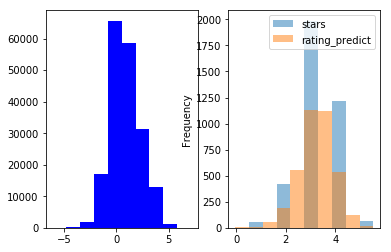

In [12]:
# spot check on known user with many reviews (>3000) in trainset

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = np.dot(user_latent[u_id,:],item_latent.T) # compute all predictions for the user of interest
if svd.trainset.offset != 0: # adjust for rating offset if offset is not 0, here offset = 0
    prediction -= svd.trainset.offset 

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

As shown, although for a subset of businesses actually rated by the user of interest, the distribution of predicted ratings are similar to reality. But the overall distribution of predicted ratings for all businesses is centered around -0.5 to 1.5, with a mean of 0.86 and a range of -6.1 to 7.1, which is not ideal given that the actual rating takes integer values of 1-5 only. 

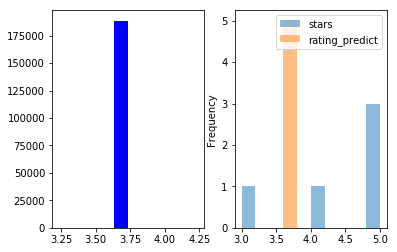

In [13]:
# unknown user (user with no review in trainset)

prediction = [mean] * item_latent.shape[0]

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'bSHpGSRn91ohVTmnyyEsdg'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

For unknow user, this model only returns the same global mean rating computed based on the trainset as the predicted rating for all business. 

### 2.2.2 SVD algorithm with bias
Similar to 2.2.1, scikit-surprise package is used to handle some of the implementation details.

The matrix factorization with bias is achieved by using the SVD algorithm and setting the biased parameter to True. 
That is the rating is predicted as: 
$$r̂_ui=μ+b_u+b_i+q^T_ip_u$$
where $p_u$ is the user latent factor matrix, $q_i$ is the item latent factor matrix, b_u is the bias terms for users, b_i is the bias terms for items, and $\mu$ is global mean rating.
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [14]:
%%time
# SVD bias model with defaults
svd_bias = SVD(n_factors=20, n_epochs = 30, biased=True) # initiate a SVD algorithm object with the bias terms
svd_bias.fit(training) # training on the trainset
pred_svd_bias = svd_bias.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd_bias) # compute RMSE score

# extract useful information from the fitted model
mean = svd_bias.trainset.global_mean # global mean rating of the trainset
# user and item matrix with latent features
user_latent, item_latent = svd_bias.pu, svd_bias.qi
print(user_latent.shape, item_latent.shape)
# user and item bias vector
user_bias, item_bias = svd_bias.bu, svd_bias.bi
print(user_bias.shape, item_bias.shape)

RMSE: 1.2758
(1435095, 20) (188558, 20)
(1435095,) (188558,)
CPU times: user 3min 57s, sys: 1.79 s, total: 3min 59s
Wall time: 3min 59s


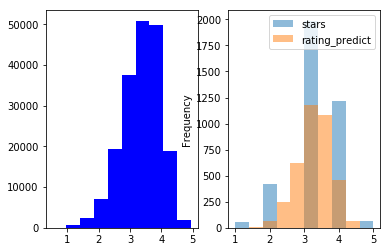

In [15]:
# spot check on known user with many reviews (>3000) in trainset

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
# compute all predictions for the user of interest
prediction = mean + user_bias[u_id] + item_bias + np.dot(user_latent[u_id,:],item_latent.T)
if svd_bias.trainset.offset != 0: # adjust for rating offset if offset is not 0, here offset = 0
    prediction -= svd_bias.trainset.offset 

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

As shown, the predicted ratings from the SVD with bias model show a much better improvement:<br>
1) for the subset of businesses actually rated by the user of interest, the distribution of predicted ratings better resembles the reality. <br>
2) the overall distribution of predicted ratings for all businesses is centered around rating of 3-4, with a mean of 3.36 and a range of 0.53 to 4.94, a much better match to the expected values (1,2,3,4 or 5). <br>

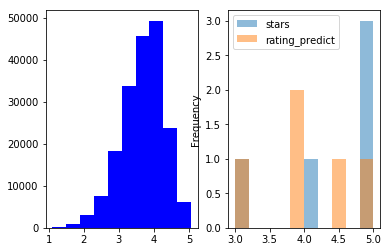

In [16]:
# unknown user (user with no review in trainset)

# compute prediction
prediction = mean + item_bias

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'bSHpGSRn91ohVTmnyyEsdg'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

In addition, as shown above, the predicted ratings for unseen user is not just the global mean, instead, it returns the global mean plus the item bias vector (global item preference based on the trainset) as the predicted ratings for all businesses. This enables an unique predicted rating for each business even for unseen users. As shown, the rating distribution for unseen users is centered around 3-4.5 with a mean of 3.68 and a range of 1.11-5.05. This is a very realistic range and the mean matches well with the global mean rating of 3.74 as well.

### 2.2.3 NMF algorithm (without bias)

Similar to 2.2.1, scikit-surprise package is used to handle some of the implementation details.

The non-negative matrix factorization (NMF) is achieved by using the NMF algorithm. The default without user and item bias terms is used here. 
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

In [17]:
%%time
# simple NMF model
nmf = NMF(n_factors=20, n_epochs = 30, biased=False) # initiate a NMF algorithm object
nmf.fit(training) # training on the trainset
pred_nmf = nmf.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

# user and item matrix with latent features
mean = nmf.trainset.global_mean # global mean rating of the trainset
user_latent, item_latent = nmf.pu, nmf.qi
print(user_latent.shape, item_latent.shape)

RMSE: 1.4282
(1435095, 20) (188558, 20)
CPU times: user 5min 58s, sys: 8.28 s, total: 6min 6s
Wall time: 6min 7s


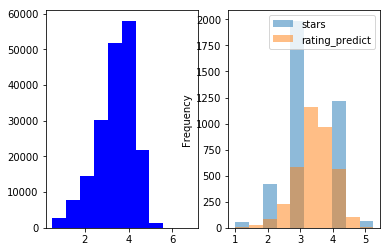

In [18]:
# spot check on known user with many reviews (>3000) in trainset

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = np.dot(user_latent[u_id,:],item_latent.T) # compute all predictions for the user of interest
if nmf.trainset.offset != 0: # adjust for rating offset if offset is not 0, here offset = 0
    prediction -= nmf.trainset.offset 

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

As shown, the predicted ratings from NMF without bias also show reasonable results:<br> 
1) for a subset of businesses actually rated by the user of interest, the distribution of predicted ratings are similar to reality. <br>
2) The distribution of predicted ratings for all businesses centers around rating of 3-4.5, with a mean of 3.41 and a range of 0.54 to 6.84. Both the mean and the range are considered reasonable.<br>

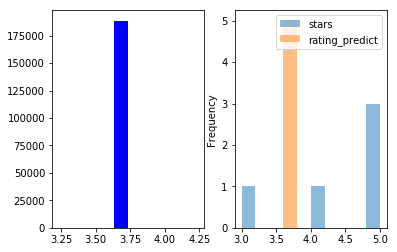

In [19]:
# unknown user (user with no review in trainset)

prediction = [mean] * item_latent.shape[0]

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'bSHpGSRn91ohVTmnyyEsdg'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

Similar to the simple SVD model, for unknow user, this simple NMF model only returns the same global mean rating computed based on the trainset as the predicted rating for all business. 

### 2.2.4 NMF with bias terms

Similar to the SVD model with bias terms, the bias terms can also be added to the non-negative matrix factorization (NMF) algorithm by setting 'biased=True' argument. https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

In [20]:
%%time
# NMF bias model with defaults
nmf_bias = NMF(n_factors=20, n_epochs = 30, biased=True) # initiate a NMF algorithm object with the bias terms
nmf_bias.fit(training) # training on the trainset
pred_nmf_bias = nmf_bias.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf_bias) # compute RMSE score

# extract useful information from the fitted model
mean = nmf_bias.trainset.global_mean # global mean rating of the trainset
# user and item matrix with latent features
user_latent, item_latent = nmf_bias.pu, nmf_bias.qi
print(user_latent.shape, item_latent.shape)
# user and item bias vector
user_bias, item_bias = nmf_bias.bu, nmf_bias.bi
print(user_bias.shape, item_bias.shape)

RMSE: 1.9529
(1435095, 20) (188558, 20)
(1435095,) (188558,)
CPU times: user 5min 56s, sys: 7.9 s, total: 6min 4s
Wall time: 6min 5s


In [21]:
# spot check on known user with many reviews (>3000) in trainset

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
# compute all predictions for the user of interest
prediction = mean + user_bias[u_id] + item_bias + np.dot(user_latent[u_id,:],item_latent.T)
if nmf.trainset.offset != 0: # adjust for rating offset if offset is not 0, here offset = 0
    prediction -= nmf_bias.trainset.offset 

# plot the distribution of predicted ratings for all businesses
print(pd.Series(prediction).describe())

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
print(comparison[['stars','rating_predict']].describe())

count    188558.000000
mean          0.009477
std         350.394261
min      -88786.793987
25%           1.075281
50%           1.994412
75%           3.202989
max       26454.570770
dtype: float64
             stars  rating_predict
count  3739.000000     3739.000000
mean      3.218775        2.204241
std       0.719119       36.145137
min       1.000000     -980.597190
25%       3.000000        1.268623
50%       3.000000        2.156666
75%       4.000000        3.331386
max       5.000000     1064.024028


As shown, non-negative matrix factorization with bias terms actually give much worse predictions: <br> 
not only is the distribution of predicted ratings for all businesses spreading over a much wider range from -88786 to 26454, with a mean of 0.009, but also the distribution of predicted ratings for the actual rated businesses are far off from reality.

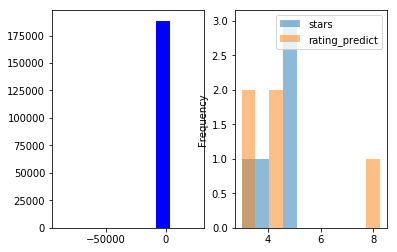

In [22]:
# unknown user (user with no review in trainset)

# compute prediction
prediction = mean + item_bias

# plot the distribution of predicted ratings for all businesses
_, (ax1, ax2) = plt.subplots(1, 2);
ax1.hist(prediction, color='blue')

# compare ratings for the rated businesses only
comparison = review_r[review_r.user_id == 'bSHpGSRn91ohVTmnyyEsdg'].set_index('business_id')
comparison['rating_predict'] = np.nan
for b_id in comparison.index:
    b_idx = training.to_inner_iid(b_id) # convert 'business_id' to item latent feature matrix indice
    comparison.loc[b_id,'rating_predict'] = prediction[b_idx] # extract the corresponding prediction
comparison[['stars','rating_predict']].plot(kind='hist', alpha=0.5, ax=ax2);

For unseen users, the predicted ratings also distribute in an unrealistic wide range of -88785 to 26456, with a mean of 1.63, off from the global mean of 3.74.<br>

This suggests that the benefit of non-negative matrix factorization is thrown off by having additional bias items, especially the large item bias terms. As a result, the predicted ratings are no longer non-negative. Having a large regularization terms on user and item bias parameters will help, but this will just push it back to the NMF algorithm without bias. Therefore, NMF with bias terms is definitely not suitable for the matrix factorization purpose here. 

### 2.3 NMF using scikit-learn

The NMF module from sklearn.decomposition.NMF is also experimented for completing the user x business matrix for rating prediction. To apply the sklearn NMF module, the user x business rating matrix needs to be extracted from the review dataframe first.<br>

Attempting to use Pandas pivot method to convert 'review' dataframe to the user x business matrix did not work out, as the resulting user x business matrix in the dense form takes up too much memory, which is unrealistic on any personal computers. <br>

Alternatively, the target matrix is very sparse, therefore to make it work with the memory constrain, the 'stars' rating in the 'review' dataframe needs to be pivoted into a sparse matrix directly by 'user_id' and 'business_id', and the available star ratings are stored as values in the sparse matrix.

In [23]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [24]:
# define method for pivoting dataframe into a sparse matrix directly

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

# return the resulting sparse matrix along with the mapping dictionaries of matrix indices to the orignial values in the corresponding columns of df
def df_pivot_sparse_matrix(df, idx, col, val):
    """pivot a pandas dataframe into sparse matrix directly using scipy.sparse.csr_matrix and return the resulting sparse matrix, 
    necessary when the df is large and pandas pivot (dense matrix) doesn't work due to space (memory) constrain. 
    ---
    input
    df: the pandas dataframe of interest
    idx: the column name of the df to be used as the index in the sparse matrix;
    col: the column name of the df to be used as the column in the sparse matrix;
    val: the column name of the df to be used as the actual value in the sparse matrix;
    ---
    return:
    sparse_matrix: the resulting sparse matrix
    map_idx: the dictionary to map the unique values in the idx column of the original df to the numerical row indices of the sparse matrix 
    map_col: the dictionary to map the uniqe values in the col column of the original df to the numerical column indices of the sparse matrix 
    ---
    note: there should be only one unique value of each idx, col combination
    """
    idx_c = CategoricalDtype(sorted(df[idx].unique()),ordered=True) # find unique values in the idx column and define as a categorical type
    col_c = CategoricalDtype(sorted(df[col].unique()),ordered=True) # find unique values in the col column and define as a categorical type

    x = df[idx].astype(idx_c).cat.codes # cast columns to the newly created categorical type and access the underlying integer codes (corresponding numbering of the categories)
    y = df[col].astype(col_c).cat.codes 
    sparse_matrix = csr_matrix((df[val].values, (x, y)), \
                           shape=(len(idx_c.categories), len(col_c.categories))) # map to the sparse matrix
    
    map_idx = dict(zip(list(idx_c.categories),np.arange(len(idx_c.categories)))) # create the mapping dictionaries
    map_col = dict(zip(list(col_c.categories),np.arange(len(col_c.categories))))
                               
    return sparse_matrix, map_idx, map_col

In [25]:
# convert trainset to sparse matrix
trainset_m, train_map_user, train_map_business = df_pivot_sparse_matrix(trainset, 'user_id', 'business_id', 'stars')

# inspect the returned sparse matrix
print("matrix shape:", trainset_m.shape)
print("memory use: {} Mb".format((trainset_m.data.nbytes + trainset_m.indptr.nbytes + trainset_m.indices.nbytes)*0.125*1e-6))
print(trainset_m.dtype)

# inspect the returned mapping dictionaries
print(list(train_map_user.items())[:3])
print(list(train_map_business.items())[:5])

matrix shape: (1435095, 188558)
memory use: 8.813486 Mb
int64
[('---1lKK3aKOuomHnwAkAow', 0), ('---89pEy_h9PvHwcHNbpyg', 1), ('---94vtJ_5o_nikEs6hUjg', 2)]
[('--1UhMGODdWsrMastO9DZw', 0), ('--6MefnULPED_I942VcFNA', 1), ('--7zmmkVg-IMGaXbuVd0SQ', 2), ('--8LPVSo5i0Oo61X01sV9A', 3), ('--9QQLMTbFzLJ_oT-ON3Xw', 4)]


In [26]:
# compute global mean of ratings based on the trainset
global_mean_train = trainset.stars.mean()
global_mean_train

3.7359005219654597

In [27]:
# function to compute RMSE based on the testset
def compute_performance(testset, user_matrix, item_matrix, user_mapper, item_mapper):
    """ Predict and compute the RMSE(root mean squared error) of the predicted ratings vs true ratings on the testset
    Return the RMSE and the list of predicted ratings
    """
    y_true = list(testset.stars.values)
    y_pred = list()
    
    for idx in testset.index:
        u, b, r = testset.loc[idx, ['user_id','business_id','stars']]
        if (u in user_mapper) and (b in item_mapper):
            u_i, b_i = user_mapper[u], item_mapper[b]
            r_pred = np.dot(user_matrix[u_i,:], item_matrix[:,b_i])
        else: 
            r_pred = global_mean_train  # return global mean rating for unseen user or restaurant
        y_pred.append(r_pred)
    
    assert len(y_true) == len(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse), y_pred

In [28]:
%%time

# initiate a NMF algorithm and fit to the trainset
model = NMF(n_components=20, tol=5e-5)
W = model.fit_transform(trainset_m) # W is the user x latent feature matrix
H = model.components_ # H is the latent feature x item matrix
print(W.shape, H.shape)

# test on the testset
rmse, pred = compute_performance(testset, W, H, train_map_user, train_map_business)
print(rmse) # RMSE on the testset

(1435095, 20) (20, 188558)
3.7264941203206052
CPU times: user 11min 48s, sys: 27.1 s, total: 12min 15s
Wall time: 12min 11s


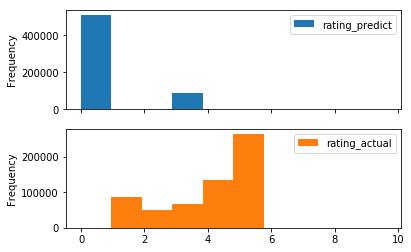

In [29]:
# look at the predicted ratings vs actual ratings in the testset
comparison = pd.concat([pd.Series(pred), pd.Series(testset.stars.values)], axis=1)
comparison.columns = ['rating_predict','rating_actual']
comparison.plot(kind='hist', subplots=True);

The NMF from sklearn gives much worse rating predictions, with RMSE on the testset being 3.73. As shown, the predicted ratings are bimodally distributed in the range of 0-1 and 3-4, with the average predicting rating being 0.58 and the max predicted rating being 9.6, too far off from reality. Therefore, non-negative matrix factorization using scikit-learn.decomposition.NMF is not used.

# 3. Optimization and evaluation of matrix factorization algorithms

As shown above, both the SVD with bias model and the simple NMF model from scikit-surprise package show promising results for the matrix factorization problem in this case. Therefore, both models are optimized via gridsearch cross validation below, and the best model is further evaluted by a variety of metrics. 

## 3.1 Gridsearch optimization of SVD bias model

In [31]:
%%time

# parameter optimization with scikit-surprise SVD algorithm with bias

# cross validation to optimize parameters of SVD with bias
param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50,100,200], 'lr_all': [0.005],'reg_all': [0.05], 'biased': [True]}
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=42), joblib_verbose=2)
svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# best RMSE score
print(svd_gs.best_score)
# combination of parameters that gave the best RMSE score
print(svd_gs.best_params)

# update SVD bias model with optimized parameters
svd_gs_best = svd_gs.best_estimator['rmse']  # algorithm with the optimized parameters
svd_gs_best.fit(training)
pred_svd_gs_best = svd_gs_best.test(testing) 
accuracy.rmse(pred_svd_gs_best)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 432.9min finished


{'rmse': 1.2860802563760216}
{'rmse': {'n_factors': 10, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.05, 'biased': True}}
RMSE: 1.2777
CPU times: user 7h 7min 6s, sys: 7min 20s, total: 7h 14min 27s
Wall time: 7h 19min 11s


## 3.2 Gridsearch optimization of simple NMF model

In [64]:
%%time

# parameter optimization with scikit-surprise NMF algorithm with no bias

from surprise import NMF
# cross validation to optimize parameters of NMF with no bias
param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50],'biased': [False]}
nmf_gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=KFold(3, random_state=42), joblib_verbose=2)
nmf_gs.fit(data_train) # gridsesarch optimization on the trainset, need to feed in a Dataset object not a trainset object

# best RMSE score
print(nmf_gs.best_score)
# combination of parameters that gave the best RMSE score
print(nmf_gs.best_params)

# update simple NMF model with optimized parameters
nmf_gs_best = nmf_gs.best_estimator['rmse']  # algorithm with the optimized parameters
nmf_gs_best.fit(training)
pred_nmf_gs_best = nmf_gs_best.test(testing)
accuracy.rmse(pred_nmf_gs_best)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 106.6min finished


{'rmse': 1.4514974026492178}
{'rmse': {'n_factors': 50, 'n_epochs': 50, 'biased': False}}
RMSE: 1.4289
CPU times: user 1h 57min 58s, sys: 5min 52s, total: 2h 3min 50s
Wall time: 2h 4min 41s


As shown above, the optimized SVD with bias model provides a better performance:<br> 
Not only does it have the lowest RMSE, but also, instead of returning a global mean rating for all restaurants in the case of unseen users, it actually returns an item-specific rating for individual restaurants as a result of having the item bias vector.<br> 
Therefore, the optimized SVD with bias model is selected as the best model for further evaluation and will be implemented in the actual collaborative recommender module.

## 3.3 RMSE of the best model

As concluded, the optimized SVD with bias model is selected as the best model for further evaluation. Here, RMSEs are computed based on various types of testset.

### 1) Testset with the presence of new users and new businesses

In [33]:
pred_1 = svd_gs_best.test(testing) # predict ratings for the testset with unseen users and businesses
accuracy.rmse(pred_1) # compute RMSE score

RMSE: 1.2777


1.277700774225839

### 2) Testset with no new user or business

In [34]:
# prepare a reduced testset, 'testset_2', by removing the unseen users and businesses
testset_2 = testset[testset.user_id.isin(trainset.user_id.unique())] # remove unseen users
testset_2 = testset_2[testset_2.business_id.isin(trainset.business_id.unique())] # remove unseen businesses
print(len(testset),len(testset_2))

# load testset_2 without unseen users and businesses into scikit-surpise 
data_test_2 = Dataset.load_from_df(testset_2, reader)
testing_2 = data_test_2.construct_testset(data_test_2.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

pred_2 = svd_gs_best.test(testing_2) # predict ratings
accuracy.rmse(pred_2) # compute RMSE score

599700 513755
RMSE: 1.2443


1.244346534114894

### 3) Testset containing only users and businesses with more than 5 historical ratings (more than 5 ratings in trainset)

In [35]:
# compute user review counts and business review counts from the trainset
user_rev_cnt = trainset.groupby('user_id').count().stars
busi_rev_cnt = trainset.groupby('business_id').count().stars

# prepare a reduced testset,'testset_3', by removing users and businesses with less than 5 historical ratings in the trainset
testset_3 = testset[testset.user_id.isin(user_rev_cnt[user_rev_cnt>=5].index)] # remove users with less than 5 ratings for training
testset_3 = testset_3[testset_3.business_id.isin(busi_rev_cnt[busi_rev_cnt>=5].index)] # remove businesses with less than 5 ratings for training
print(len(testset),len(testset_3))

# load testset_3 containing only users and businesses with at least 5 historical ratings
data_test_3 = Dataset.load_from_df(testset_3, reader)
testing_3 = data_test_3.construct_testset(data_test_3.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

pred_3 = svd_gs_best.test(testing_3) # predict ratings
accuracy.rmse(pred_3) # compute RMSE score

599700 348231
RMSE: 1.1884


1.1884182097567475

As shown, the RMSE on testset with unseen users and businesses is 1.277, whereas the RMSE on testset without any new user or business is lower 1.244. Also, the predicted ratings become more accurate for users and restaurants with rich user history, as RMSE further drops to 1.188 if only predicting for users and businesses with at least five ratings.<br>

This also suggests that the model prediction performance (RMSE) is limited initially as the historical data is very limited, but should improve over time as system accumulates more user and business preference(ratings) over time.

## 3.4 NDCG of recommendation ranking by the predicted ratings from the best model

NDCG (Normalized Discounted Cumulative Gain), which works well in this case with review ratings of 1 to 5, is chosen over MAP (Mean average precision), which only assumes binary relevance (interesting or not, click or not).

DCG(Discounted Cumulative Gain) is calculated as the sum of the gain (relevance score) of item at each position in the ranking list, discounted by their position i. 
$$DCG(Rank)=∑_iu_i * d_i$$
where $u_i$ is the gain of item at ranking position $i$, and $d_i$ is the discount of item at ranking position $i$. 
The discount $d$ is a function that decreases with position further down the list:
$$d_i=\frac{1}{log_2(i+1)}$$

NDCG is calculated as the actual DCG normalized by maximum achievable DCG (a perfect ranking in the descreasing order of the relevance score) 
$$nDCG(Rank)=\frac{DCG(Rank)}{DCG(Perfect Rank)}$$

Note: nDCG is increasingly popular, as it works well with a variety type of relevance scores, binary, integar or float numbers.

--- 
Here, ratings are predicted both for testset with new user and business and for testset with no new users or business ('testset_2') using the best model concluded above.<br> The remmendation ranking is generated for each user in the testset based on the predicted ratings in the descending order, and then NDCG@top10 and NDCG@5 are computed.

In [36]:
# function for computing normalized Discounted Cumulative Gain as the ranking metric
# inspired by https://gist.github.com/bwhite/3726239

def dcg_at_k(r, k):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values, in this case, the review rating ranging 1-5. 
    Discount starts to take effect from the second item in the list, with the weights being 1/log2(rank position+1)
    (Weights being [1.0, 0.6309, 0.5, 0.4307, 0.3869, ...] for the first items in the rank)
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    ---
    Args:
        r: a list or numpy 1D array of relevance scores corresponding to the rank order
        k: Number of results to consider (consider only top-k)
    ---
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:min(len(r),k)]  # convert to float-type numpy array and extract only top-k
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return None

def ndcg_at_k(r, k):
    """Score is normalized discounted cumulative gain (ndcg), normalized by the maximum achievable DCG (Discounted Cumulative Gain)
    ---
    Args:
        Same as dcg_at_k(r,k)
    ---
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k) # compute the maximum achievable DCG based on the perfect ranking
    dcg = dcg_at_k(r, k) # compute the actual DCG based on the actual ranking
    if dcg_max == None or dcg == None:
        return None
    return dcg/dcg_max

### 1) Testset with the presence of new users and new businesses

In [37]:
pred_1 = svd_gs_best.test(testing) # predict on testset with new users and businesses

In [38]:
rating_predict_1 = pd.DataFrame(index=np.arange(len(pred_1)),columns=['user_id','business_id','stars','rating_predict'])

i=0
for entry in tqdm(pred_1):
    rating_predict_1.iloc[i,:] = entry.uid, entry.iid, entry.r_ui, entry.est
    i += 1    
assert i == len(pred_1)

100%|██████████| 599700/599700 [9:47:37<00:00,  9.62it/s]   


In [39]:
# save the predicted ratings to file
with open('rating_predict_collaborative_testset_1.pkl','wb') as f:
    pickle.dump(rating_predict_1, f)

In [40]:
%%time
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # 12 review ratings available in 'testset'

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

# filter to the user_id of interest only
rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
print('Ranking by predicted ratings:\n', rec)
ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by predicted ratings:
                        rating_predict stars
business_id                                
DXlDzOcpdUE_F21tok0fgw        4.97161     4
gVhX5xcnGjHE3mF2eXqKYg         4.6949     5
eJKnymd0BywNPrJw1IuXVw        4.66488     5
SvHAczHxIJ00QlJ9ovQR8g        4.59764     4
RJtgNpUFthlJ5grLr16GxA        4.41994     5
Ks0M3J4vZAKsHPuCINz5fQ        4.27252     4
TTpgjbrSyxwHHzE5bIF-Rw         4.2718     3
NAuUGBenC_TJoj2c6y9rbg        3.68518     5
x-80R4DE6AsYoDtA2H-sKw        3.58008     3
pwLQfEe_yJYwAWWugWbpIQ        3.37864     4
Xspg78dOvuedvuPEUwZBjw         3.3126     4
PSRZaGGxXmOmabL2si8pKw        3.10716     3

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.9474901457458933
CPU times: user 1.46 s, sys: 82.6 ms, total: 1.55 s
Wall time: 1.61 s


In [41]:
%%time
# evaluate NDCG@top10 on the entire testset

# only look at NDCG scores for users with at least 10 ratings available in the testset in order to evaluate NDCG@top10
rev_count_by_user = rating_predict_1.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

ndcg_scores_1_10 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 10
    ndcg = ndcg_at_k(r=rec.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_1_10.append(ndcg)

100%|██████████| 4642/4642 [06:34<00:00, 11.77it/s]

CPU times: user 6min 34s, sys: 2.05 s, total: 6min 36s
Wall time: 6min 36s


In [42]:
%%time
# evaluate NDCG@top5 on the entire testset

# only look at NDCG scores for users with at least 5 ratings available in the testset in order to evaluate NDCG@top5
rev_count_by_user = rating_predict_1.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_1 = rating_predict_1.sort_values('rating_predict', ascending=False)

ndcg_scores_1_5 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_1[rating_predict_1.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 5
    ndcg = ndcg_at_k(r=rec.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_1_5.append(ndcg)

100%|██████████| 15983/15983 [22:28<00:00, 11.85it/s]

CPU times: user 22min 27s, sys: 5.69 s, total: 22min 33s
Wall time: 22min 30s


### Testset with no new user or business

In [43]:
pred_2 = svd_gs_best.test(testing_2) # predict on testset_2 with no new user or business

In [44]:
rating_predict_2 = pd.DataFrame(index=np.arange(len(pred_2)),columns=['user_id','business_id','stars','rating_predict'])

i=0
for entry in tqdm(pred_2):
    rating_predict_2.iloc[i,:] = entry.uid, entry.iid, entry.r_ui, entry.est
    i += 1    
assert i == len(pred_2)

100%|██████████| 513755/513755 [7:21:36<00:00, 19.39it/s]     


In [45]:
# save the predicted ratings to file
with open('rating_predict_collaborative_testset_2.pkl','wb') as f:
    pickle.dump(rating_predict_2, f)

In [46]:
%%time
# look at a particular user_id as an example

user_id = '---1lKK3aKOuomHnwAkAow' # 12 review ratings available in 'testset_2'

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

# filter to the user_id of interest only
rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
print('Ranking by predicted ratings:\n', rec)
ndcg = ndcg_at_k(r=rec.stars.values, k=10) # look at the NDCG score@top10
print('\nNormalized discounted cumulative gain achieved at top-10 based on testset:\n', ndcg)

Ranking by predicted ratings:
                        rating_predict stars
business_id                                
DXlDzOcpdUE_F21tok0fgw        4.97161     4
gVhX5xcnGjHE3mF2eXqKYg         4.6949     5
eJKnymd0BywNPrJw1IuXVw        4.66488     5
SvHAczHxIJ00QlJ9ovQR8g        4.59764     4
RJtgNpUFthlJ5grLr16GxA        4.41994     5
Ks0M3J4vZAKsHPuCINz5fQ        4.27252     4
TTpgjbrSyxwHHzE5bIF-Rw         4.2718     3
NAuUGBenC_TJoj2c6y9rbg        3.68518     5
x-80R4DE6AsYoDtA2H-sKw        3.58008     3
pwLQfEe_yJYwAWWugWbpIQ        3.37864     4
Xspg78dOvuedvuPEUwZBjw         3.3126     4
PSRZaGGxXmOmabL2si8pKw        3.10716     3

Normalized discounted cumulative gain achieved at top-10 based on testset:
 0.9474901457458933
CPU times: user 1.08 s, sys: 28.2 ms, total: 1.11 s
Wall time: 1.13 s


In [47]:
%%time
# evaluate NDCG@top10 on the entire testset_2

# only look at NDCG scores for users with at least 10 ratings available in the testset_2 in order to evaluate NDCG@top10
rev_count_by_user = rating_predict_2.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 10].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

ndcg_scores_2_10 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 10
    ndcg = ndcg_at_k(r=rec.stars.values, k=10) # compute NDCG score@top10
    ndcg_scores_2_10.append(ndcg)

100%|██████████| 4641/4641 [05:26<00:00, 14.21it/s]

CPU times: user 5min 26s, sys: 1.93 s, total: 5min 28s
Wall time: 5min 28s


In [48]:
%%time
# evaluate NDCG@top5 on the entire testset_2

# only look at NDCG scores for users with at least 5 ratings available in the testset_2 in order to evaluate NDCG@top5
rev_count_by_user = rating_predict_2.groupby('user_id').business_id.count()
user_id_of_interest = rev_count_by_user[rev_count_by_user >= 5].index

# rank the 'rating_predict' dataframe by the predicted ratings in descending order
rating_predict_2 = rating_predict_2.sort_values('rating_predict', ascending=False)

ndcg_scores_2_5 = []
# compute NDCG score for each user in the testset
for user_id in tqdm(user_id_of_interest):
    
    # filter to the user_id of interest only
    rec = rating_predict_2[rating_predict_2.user_id == user_id].set_index('business_id')[['rating_predict','stars']]
    assert len(rec) >= 5
    ndcg = ndcg_at_k(r=rec.stars.values, k=5) # compute NDCG score@top5
    ndcg_scores_2_5.append(ndcg)

100%|██████████| 15980/15980 [18:41<00:00, 14.30it/s]

CPU times: user 18min 39s, sys: 5.71 s, total: 18min 45s
Wall time: 18min 43s


,NDCG@10_collaborative_testset_with_new,NDCG@10_collaborative_testset_no_new,NDCG@5_collaborative_testset_with_new,NDCG@5_collaborative_testset_no_new
count,4642.000000,4641.000000,15983.000000,15980.000000
mean,0.904994,0.904952,0.908310,0.908326
std,0.068203,0.068165,0.089472,0.089520
min,0.497472,0.497472,0.338880,0.338880
25%,0.868901,0.868893,0.864565,0.864545
50%,0.918245,0.918069,0.932168,0.932168
75%,0.954815,0.954917,0.974209,0.974546
max,1.000000,1.000000,1.000000,1.000000


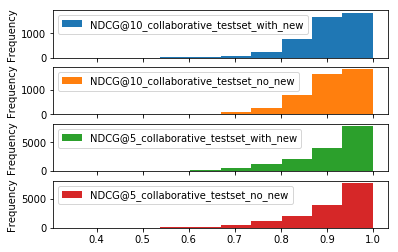

In [49]:
# save the computed NDCG scores of the testset to file
ndcg_scores = [pd.Series(i) for i in [ndcg_scores_1_10, ndcg_scores_2_10, ndcg_scores_1_5, ndcg_scores_2_5]]
ndcg_scores = pd.concat(ndcg_scores, axis=1)
ndcg_scores.columns = ['NDCG@10_collaborative_testset_with_new','NDCG@10_collaborative_testset_no_new',\
                      'NDCG@5_collaborative_testset_with_new','NDCG@5_collaborative_testset_no_new',]

# save the NDCG scores to file
with open('ndcg_collaborative_svd.pkl','wb') as f:
    pickle.dump(ndcg_scores, f)
    
ndcg_scores.plot(kind='hist',subplots=True);
ndcg_scores.describe()

As shown, the average NDCG@10 and NDCG@5 scores are 0.905 and 0.908, significantly higher than the average NDCG scores (~0.86) obtained by the content-based recommender module. The difference between testset with new user and business and testset with no new user or business is not significant, as there is 1 review involving new user/business out of 4642 reviews for computing NDCG@10, and only 3 involving new user/business out of 15983 reviews for computing NDCG@5.<br>

Note: 
These rating prediction for the testset include ratings of non-restaurant businesses, thus the resulting recommendation rankings include non-restaurant businesses. NDCG scores are also computed based on the same testset after removing non-restaurant business and the results are very similar (a collection of 2215 NDCG scores for NDCG@10 with a mean of 0.904817 and a std of 0.067366). For actual implementation, after generating the recommendation ranking, a followup step will be added to filter out the non-restaurant businesses.

In [50]:
# free up temporary variables to save memory
idx, trainset, testset, data_train, training, data_test, testing = 0,0,0,0,0,0,0
svd, svd_bias, nmf, nmf_bias, pred_svd, pred_svd_bias, pred_nmf, pred_nmf_bias = 0,0,0,0,0,0,0,0
user_latent, item_latent, user_bias, item_bias, prediction, comparison = 0,0,0,0,0,0
trainset_m, train_map_user, train_map_business, model, W, H, pred = 0,0,0,0,0,0,0
svd_gs, svd_gs_best, pred_svd_gs_best, nmf_gs, nmf_gs_best, pred_nmf_gs_best = 0,0,0,0,0,0
pred_1, pred_2, pred_3, testset_2, testing_2, testset_3, testing_3, user_rev_cnt, busi_rev_cnt = 0,0,0,0,0,0,0,0,0
rating_predict_1, rating_predict_2, rating_predict_3, rec, rev_count_by_user, user_id_of_interest = 0,0,0,0,0,0
ndcg_scores_1_10, ndcg_scores_1_5, ndcg_scores_2_10, ndcg_scores_2_5, ndcg_scores = 0,0,0,0,0

# 4. Implementation of the collaborative recommender module

As concluded, the SVD with bias model from scikit-surprise package gives very reasonable performance both in rating prediction and in generating recommendation ranking. Therefore, the optimized SVD with bias model is selected for implementing the collaborative filtering module.

## 4.1 Re-training on entire dataset

Previously, all models are trained on the trainset only. Prior to implementation, the best performing SVD with bias model with the optimized parameters is re-trained taking advantage of the entire review dataset and saved to file for use later in the recommender module.

In [51]:
%%time

# load the entire dataset into Surprise
data = Dataset.load_from_df(review_r[['user_id','business_id','stars']], reader)
# use the optimized SVD algorithm parameters and re-train on the entire dataset
svd_bias = SVD(n_factors=10, n_epochs = 50, lr_all=0.005, reg_all=0.05, biased=True) # initiate a SVD algorithm object with the bias terms

svd_bias.fit(data.build_full_trainset()) # prepare a trainset object out of the entire dataset to feed to .fit() method
pred_svd_bias = svd_bias.test(data.construct_testset(data.raw_ratings)) # prepare a testset object out of the entire dataset to feed to .test() method
accuracy.rmse(pred_svd_bias) # compute RMSE score

RMSE: 0.8603
CPU times: user 6min 28s, sys: 1min 33s, total: 8min 2s
Wall time: 9min 4s


note: here the 'RMSE' of 0.86 is lower than the 'RMSE' obtained above on the testset, because the 'RMSE' here is computed on the trainset. 

In [52]:
# check there is no offset term (otherwise all prediction need to be adjusted by the offset)
assert svd_bias.trainset.offset == 0

# wrap all useful info from the trained model in a dictionary and pickle to file
svd_trained_info = {'user_latent': svd_bias.pu,
                    'item_latent': svd_bias.qi,
                    'user_bias': svd_bias.bu,
                    'item_bias': svd_bias.bi,
                    'mean_rating': svd_bias.trainset.global_mean,
                    'userid_to_index': svd_bias.trainset._raw2inner_id_users,
                    'itemid_to_index': svd_bias.trainset._raw2inner_id_items
                   }

In [53]:
%%time

# save all necessary information for prediction from the trained svd_bias model
with open('svd_trained_info.pkl', 'wb') as f:
    pickle.dump(svd_trained_info, f)

# save all the information regarding the trained svd_bias model as a backup (this file will be large)
with open('svd_bias_model_trained.pkl','wb') as f:
    pickle.dump(svd_bias, f)

CPU times: user 8.76 s, sys: 3.43 s, total: 12.2 s
Wall time: 14.3 s


In [54]:
# free up temporary variables to save memory
review_r, data, svd_bias, pred_svd_bias, svd_trained_info = 0,0,0,0,0

## 4.2 Implementation of the collaborative recommender module

For the actual implementation of the collaborative module: <br> 
* first, the recommendation is initiated to all the open restaurant businesses in the 'business' catalog
* secondly, user latent feature matrix, user bias vector, item latent feature matrix, item bias vector and other necessary information of the trained SVD algorithm are loaded into the module
* thirdly, given the user_id of interest, personalized ratings are predicted for all businesses in the catalog by multiplying the latent feature of this user with item latent feature matrix, then added item bias vector, user bias value of the user of interest and global mean rating.
* fourthly, the list of predicted ratings are paired with corresponding business_id and filtered to unrated businesses only based on the user_id of interest. 
* lastly, the list of predicted ratings are merged with the restaurant recommendation list based on business_id to filter out non-restaurant businesses, followed by sorting the resulting list by predicted rating in descending order to reach the final recommendation for the given user.

In [55]:
# the 'business' and 'review' datasets need to be imported for the collaborative recommender module to operate
business = pd.read_csv('business_clean.csv')
review = pd.read_csv('review_clean.csv')

In [56]:
# adding 'adjusted_score' to the 'business' dataset, which adjusts the restaurnat average star ratings by the number of ratings it has
globe_mean = ((business.stars * business.review_count).sum())/(business.review_count.sum())
k = 22 # set strength k to 22, which is the 50% quantile of the review counts for all businesses
business['adjusted_score'] = (business.review_count * business.stars + k * globe_mean)/(business.review_count + k)

In [57]:
class Recommender:
    
    def __init__(self, n=5, original_score=False):
        """initiate a Recommender object by passing the desired number of recommendations to make, the default number is 10.
        By default, the adjusted score will be used for ranking; To rank by the original average rating of the restaurant, pass original_score=True
        """
        self.n = n # number of recommendations to make, default is 5
        self.original_score = original_score # boolean indicating whether the original average rating or the adjusted score is used
        # initiate a list of column names to display in the recommendation results
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2','cuisine','style','review_count','stars','adjusted_score']
        
        # initiate the list of recommendations to be all the open restaurants from the entire catalog of 'business' dataframe sorted by the score of interest
        if self.original_score:  # set sorting criteria to the originial star rating
            score = 'stars'
        else:  # set sorting criteria to the adjusted score
            score = 'adjusted_score'
        self.recomm = business[business.is_open == 1].sort_values(score, ascending=False)
        
    def display_recommendation(self):
        """ Display the list of top n recommended restaurants
        """
        # limit the list of recommendation to only top n at max
        if self.n < len(self.recomm):
            self.recomm = self.recomm.iloc[:self.n]
        if len(self.recomm) == 0:
            print("Sorry, there is no matching recommendations.")
        else: 
            print("The top {} recommended restaurants matching your keywords are".format(self.n))
            print(self.recomm[self.column_to_display])
    
    # personalized collaborative-based filtering recommender module
    def collaborative(self, user_id=None):
        """Passing of user_id is required if personalized recommendation is desired.
        """
        
        self.user_id = user_id # user_id for personalized recommendation using collaborative filtering 
        if self.user_id is None:
            print("no user_id is provided!")
            return None
        if len(self.user_id) != 22:
            print("invalid user id!")
            return None
        
        # initiate every time the module is called
        self.recomm = business[business.is_open ==1] # start with all open restaurants from the entire 'business' catalog
        if 'predicted_stars' in self.recomm.columns:
            self.recomm.drop('predicted_stars', axis=1, inplace=True) # delete the column of 'predicted_stars' if already present
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2',\
                                  'cuisine','style','review_count','stars','adjusted_score'] # reset the columns to display
        
        # load and extract the necessary info fro the trained matrix factorization algorithm
        with open('svd_trained_info.pkl', 'rb') as f:
            svd_trained_info = pickle.load(f)
        user_latent = svd_trained_info['user_latent']
        item_latent = svd_trained_info['item_latent']
        user_bias = svd_trained_info['user_bias']
        item_bias = svd_trained_info['item_bias']
        r_mean = svd_trained_info['mean_rating'] # global mean of all ratings
        userid_to_idx = svd_trained_info['userid_to_index']
        itemid_to_idx = svd_trained_info['itemid_to_index']
        
        # predict personalized business ratings for the user_id of interest
        if self.user_id in userid_to_idx:
            u_idx = userid_to_idx[self.user_id]
            pred = r_mean + user_bias[u_idx] + item_bias + np.dot(user_latent[u_idx,:],item_latent.T)
        else: 
            print("sorry, no personal data available for this user_id yet!")
            print("Here is the generic recommendation computed from all the users in our database:")
            pred = r_mean + item_bias
        
        # pairing the predicted ratings with the business_id by matching the corresponding matrix indices of the business_id
        prediction = pd.DataFrame(data=pred, index=itemid_to_idx.values(), columns=['predicted_stars']) 
        prediction.index.name = 'matrix_item_indice'
        assert len(prediction) == len(pred)
        prediction['business_id'] = list(itemid_to_idx.keys())
        
        # filter to unrated business_id only by the user_id of interest if a personal history is available
        if self.user_id in userid_to_idx:       
            busi_rated = review[review.user_id == self.user_id].business_id.unique()
            prediction = prediction[~prediction.business_id.isin(busi_rated)]
        
        # inner-join the prediction dataframe with the recommendation catalog on 'business_id' to retrieve all relevant business informations
        # note: the .merge step needs to be performed prior to extracting the top n
        # because many of the 'business_id' in the review dataframe are not restaurant-related, therefore not present in the 'business' catalog
        # this merge will filter out the non restaurant-related businesses
        self.recomm = self.recomm.merge(prediction, on='business_id', how='inner') 
        
        # sort the prediction by the predicted ratings in descending order
        self.recomm = self.recomm.sort_values('predicted_stars', ascending=False).reset_index(drop=True)
        
        # add 'predicted_stars' to the list of columns to display
        self.column_to_display.insert(0, 'predicted_stars') 
        
        # display the list of top n recommendations
        self.display_recommendation()
        
        return self.recomm

## 4.3 Testing

In [58]:
%%time

# initiate a Recommender object
kw = Recommender(n=10)

# test0: display only (same as no keywords)
print("------\nresult from test0 (display only): ")
kw.display_recommendation()

# test1: no user id input
print("------\nresult from test1 (no user id input): ")
kw.collaborative();

# test 2: invalid user id input
print("------\nresult from test2 (invalid user id input): ")
kw.collaborative(user_id='928402');

------
result from test0 (display only): 
The top 10 recommended restaurants matching your keywords are
      state             city                                  name  \
7464     AZ          Phoenix                       Little Miss BBQ   
31910    NV        Las Vegas                          Brew Tea Bar   
45401    NV        Las Vegas                            Gelatology   
7784     NV  North Las Vegas                          Poke Express   
28162    NV        Las Vegas                    Meráki Greek Grill   
2684     AZ             Mesa                        Worth Takeaway   
14567    NV        Las Vegas                Free Vegas Club Passes   
11521    NV        Las Vegas  Paranormal - Mind Reading Magic Show   
30972    NV        Las Vegas           Desert Wind Coffee Roasters   
46284    NV        Henderson                                HUMMUS   

                            address  attributes.RestaurantsPriceRange2  \
7464           4301 E University Dr                

In [59]:
%%time

# test 3: valid user id (no user data)
print("------\nresult from test3 (valid user id --- no user review data): ")
kw.collaborative(user_id='-NzChtoNOw706kps82x0Kg');

------
result from test3 (valid user id --- no user review data): 
sorry, no personal data available for this user_id yet!
Here is the generic recommendation computed from all the users in our database:
The top 10 recommended restaurants matching your keywords are
   predicted_stars state       city  \
0         4.972518    AZ      Tempe   
1         4.952788    NV  Henderson   
2         4.939452    NV  Henderson   
3         4.937603    AZ    Phoenix   
4         4.930186    WI    Madison   
5         4.922714    AZ    Gilbert   
6         4.916148    NV  Las Vegas   
7         4.915806    NV  Las Vegas   
8         4.915574    NV  Henderson   
9         4.913130    AZ    Phoenix   

                                           name  \
0              Affordable Party & Event Rentals   
1                                    Party Pros   
2                                Firelight Barn   
3                     La Parilla Villa Catering   
4                       The Conscious Carnivore   

In [60]:
%%time

# test 4: valid user id (user has only one review)
print("------\nresult from test4 (valid user id --- user has only one review): ")
kw.collaborative(user_id='---89pEy_h9PvHwcHNbpyg');

------
result from test4 (valid user id --- user has only one review): 
The top 10 recommended restaurants matching your keywords are
   predicted_stars state        city                              name  \
0         5.162014    AZ  Scottsdale                    Aloha Cakes AZ   
1         5.158219    AZ       Tempe  Affordable Party & Event Rentals   
2         5.157192    NV   Las Vegas                  CHEFit Meal Prep   
3         5.152490    NV   Henderson                    Firelight Barn   
4         5.144190    NV   Henderson                        Party Pros   
5         5.142734    WI     Madison           The Conscious Carnivore   
6         5.141464    AZ     Gilbert           Big Island Hawaiian BBQ   
7         5.141098    AZ     Phoenix         La Parilla Villa Catering   
8         5.140764    AZ     Phoenix              Funny Magic For Kids   
9         5.137270    IL   Champaign                  Bugbee's DJ Plus   

                         address  attributes.Restau

As shown, it takes only 2 seconds to return the personalized recommendation ranks, but due to the limited user preference history, the recommendation is somewhat similar to the generic recommendation for unseen users. 

In [61]:
%%time

# test 5: valid user id (user has over 100 reviews)
print("------\nresult from test5 (valid user id --- user has over 100 reviews): ")
kw.collaborative(user_id='---1lKK3aKOuomHnwAkAow');

------
result from test5 (valid user id --- user has over 100 reviews): 
The top 10 recommended restaurants matching your keywords are
   predicted_stars state             city                         name  \
0         6.505740    NV        Las Vegas                 Kabob N More   
1         6.396645    NV        Las Vegas                  Tasty Grill   
2         6.306595    NV        Las Vegas               Tacos N' Ritas   
3         6.051560    NV        Las Vegas      KUMI by Chef Akira Back   
4         6.046227    NV  North Las Vegas      Amazing Thai Restaurant   
5         6.044021    NV        Las Vegas  Yi Mei Champion Taiwan Deli   
6         5.975990    NV        Las Vegas             Estiatorio Milos   
7         5.942602    AZ          Gilbert                Pizza A Metro   
8         5.929520    AZ          Gilbert                 Yanagi Sushi   
9         5.923629    AZ          Phoenix                The Van Buren   

                            address  attributes.Re

As shown, even for users with more review history where the module needs to filter and remove all the rated restaurants from the recommendation list, it only takes 2 seconds to return the personalized recommendation rank. Thanks to the rich personal preference history, the recommendation is really personalized. As in this case, it seems to suggest that the user prefers restaurants with a rich number of reviews (popular restaurants), reasonable to good ratings (3.5-4.5) and near the Las Vegas and Arizona area. Different from content-based module, recommendation by the collaborative module features quite a variety of cuisines. 